In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
## function to skip printing of max_iter warnings

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

plt.style.use("Solarize_Light2")

In [2]:
churn_data = pd.read_csv('/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
X = X.drop("Unnamed: 0", axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

### Random Forest Classifier:
### Introduction:


#### First Iteration:

In [3]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

y_pred_rf = random_forest.predict(X_test)
y_pred_train_rf = random_forest.predict(X_train)

rf_as = metrics.accuracy_score(y_test, y_pred_rf)
rf_as_train = metrics.accuracy_score(y_train, y_pred_train_rf)

print(f"Accuracy score for test data : {rf_as}")
print(f"Accuracy score for train data : {rf_as_train}")


Accuracy score for test data : 0.7832830676432572
Accuracy score for train data : 0.9987263850562513


<AxesSubplot:>

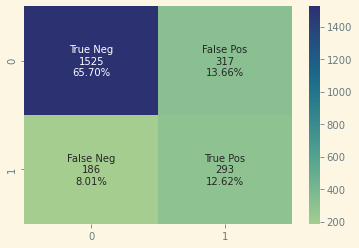

In [4]:
cf_matrix = metrics.confusion_matrix(y_pred_rf, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [5]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1711
           1       0.61      0.48      0.54       610

    accuracy                           0.78      2321
   macro avg       0.72      0.69      0.70      2321
weighted avg       0.77      0.78      0.77      2321



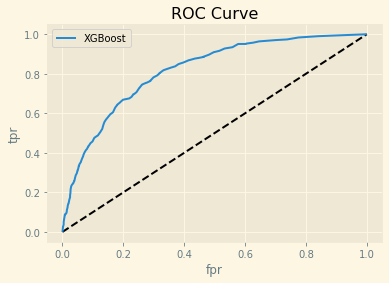

In [6]:
y_proba = random_forest.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'XGBoost')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

#### Second Iteration:
let's narrow down our features to deal with overfitting

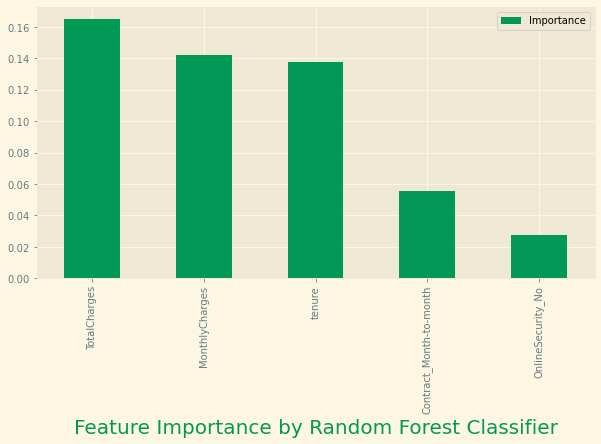

In [7]:
feature_importance_ = pd.DataFrame({'Importance' : RandomForestClassifier().fit(X, y).feature_importances_}, index = X.columns)

feature_importance_.sort_values(by = 'Importance', ascending = False, axis = 0)[:5].plot(kind = 'bar', color = '#019955', figsize = (10, 5))
plt.xlabel("Feature Importance by Random Forest Classifier", color = "#019955", fontdict= {"fontsize" : 20});

In [8]:
X_train_new_ = X_train[['MonthlyCharges', 'TotalCharges', 'tenure', 'Contract_Month-to-month', 'OnlineSecurity_No']]
X_test_new_ = X_test[['MonthlyCharges', 'TotalCharges', 'tenure', 'Contract_Month-to-month', 'OnlineSecurity_No']]

In [9]:
random_forest_new = RandomForestClassifier()
random_forest_new.fit(X_train_new_, y_train)

y_pred_rf_new = random_forest_new.predict(X_test_new_)
y_pred_train_rf_new = random_forest_new.predict(X_train_new_)

In [10]:
rf_as_new = metrics.accuracy_score(y_test, y_pred_rf_new)
rf_as_train_new = metrics.accuracy_score(y_train, y_pred_train_rf_new)

In [11]:
print(f"Accuracy score for test data : {rf_as_new}")
print(f"Accuracy score for train data : {rf_as_train_new}")

Accuracy score for test data : 0.7621714778112882
Accuracy score for train data : 0.9917215028656337


We can see that we're still overfitting, so maybe hyperparameter optimization may help us.

In [12]:
params_grid = {'criterion' : ['entropy', 'gini'], 'max_depth' : [2, 4, 6, 8], 'n_estimators' : [300, 400, 500],
              'min_samples_split' : [2, 4, 6, 8], 'min_samples_leaf' : [2, 3, 5, 7]}

# gscv_rf = GridSearchCV(RandomForestClassifier(), params_grid, cv = 3, scoring = 'f1')

# gscv_rf.fit(X_train_new_, y_train)
# print(gscv_rf.best_params_)
# {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 300}

In [13]:
rf_gscv =RandomForestClassifier(n_estimators = 300, criterion = 'entropy', max_depth = 8, min_samples_split = 8, min_samples_leaf = 2)
rf_gscv.fit(X_train_new_, y_train)

y_pred_gsvc = rf_gscv.predict(X_test_new_)
y_pred_gsvc_train = rf_gscv.predict(X_train_new_)

rf_gscv_as = metrics.accuracy_score(y_test, y_pred_gsvc)
rf_gscv_train_as = metrics.accuracy_score(y_train, y_pred_gsvc_train)

print(f"Accuracy score for test data : {rf_gscv_as}")
print(f"Accuracy score for train data : {rf_gscv_train_as}")

Accuracy score for test data : 0.7906074967686342
Accuracy score for train data : 0.828061982593929


<AxesSubplot:>

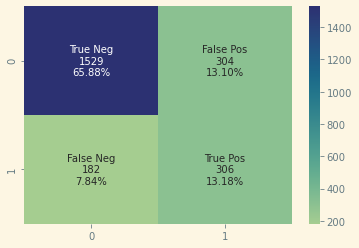

In [14]:
cf_matrix = metrics.confusion_matrix(y_pred_gsvc, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [15]:
print(metrics.classification_report(y_test, y_pred_gsvc))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1711
           1       0.63      0.50      0.56       610

    accuracy                           0.79      2321
   macro avg       0.73      0.70      0.71      2321
weighted avg       0.78      0.79      0.78      2321



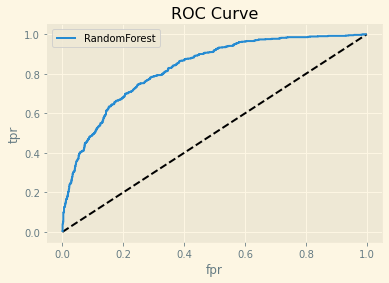

In [16]:
y_proba = rf_gscv.predict_proba(X_test_new_)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'RandomForest')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

In [18]:
k = 5
kf = KFold(n_splits=k, random_state=None)

result = cross_val_score(rf_gscv , X_train_new_, y_train, cv = kf)
mean = round(result.mean()*100, 2)
stdv = round(result.std()*100, 2)
range = [round(mean-stdv, 2), round(mean+stdv ,2)]

print("Avg accuracy: {}% +/- {}%\n range: {}".format(mean, stdv, range))

Avg accuracy: 79.16% +/- 1.42%
 range: [77.74, 80.58]
